In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers
import time
import nibabel as nib
from tqdm import tqdm
from scipy.ndimage import binary_erosion
import gc
import cv2

from IPython import display

import model

In [4]:
# generator = model.simple_generator(14, 6)
# discriminator = model.simple_discriminator(6)

In [4]:
generator = tf.keras.saving.load_model('../Models/unet_model')
# generator = tf.keras.saving.load_model('../Models/generator')
# discriminator = tf.keras.saving.load_model('../Models/discriminator_unet')

In [6]:
# generator.load_weights('Model/gen_weights')
# discriminator.load_weights('Model/disc_weights')

In [5]:
generator.inputs[0].shape, generator.outputs[0].shape

(TensorShape([None, 15, 15, 15, 14]), TensorShape([None, 9, 9, 9, 6]))

In [6]:

subj = '100307'


h4_imgs = []
h4_imgs_lr = []
dti_imgs = []
dti_imgs_lr = []

h4_funcs = []
dti_funcs = []

dti_preprocs_hr = np.zeros((6,2))
dti_preprocs_lr = np.zeros((6,2))

for i in range(1,9):

    dti_input_lr = nib.load("Data/{}/T1w/Diffusion/dt_all_lowres_2_{}.nii".format(subj,i))
    
    dti_data = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_{}.nii".format(subj,i)).get_fdata())
    dti_data_lr = np.array(dti_input_lr.get_fdata())

    # if i > 1:
    #     dti_data[dti_imgs[0] < 0] = 0
    #     dti_data_lr[dti_imgs[0] < 0] = 0

    dti_imgs.append(dti_data)
    dti_imgs_lr.append(dti_data_lr)

    dti_funcs.append(dti_input_lr.affine)

    dti_data = None
    dti_data_lr = None

for i in range(1,25):

    h4_input_lr = nib.load("Data/{}/T1w/Diffusion/h4_all_lowres_2_{}.nii".format(subj,str(i).zfill(2)))

    h4_data = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
    h4_data_lr = np.array(h4_input_lr.get_fdata())

    h4_funcs.append(h4_input_lr.affine)

    # if i > 1:
    #     h4_data[h4_data[0] < 0] = 0
    #     h4_data_lr[h4_data[0] < 0] = 0
    
    h4_imgs.append(h4_data)
    h4_imgs_lr.append(h4_data_lr)

    h4_data = None
    h4_data_lr = None

h4_imgs = np.array(h4_imgs).transpose((1,2,3,0))
h4_imgs_lr = np.array(h4_imgs_lr).transpose((1,2,3,0))

dti_imgs = np.array(dti_imgs).transpose((1,2,3,0))
dti_imgs_lr = np.array(dti_imgs_lr).transpose((1,2,3,0))

mask = h4_imgs[...,0]

binmask = np.zeros(mask.shape)

binmask[mask >= 0] = 1

mask = binary_erosion(binmask, structure=np.ones((5,5,5),np.uint8),iterations = 1)

binmask = None

# Calculate DTI ranges and normalise to range [0,1]
for i in range(2,8):

    dti_preprocs_lr[i-2,:] = np.array([np.min(mask*dti_imgs_lr[...,i]), np.max(mask*dti_imgs_lr[...,i])])
    dti_imgs_lr[mask>0, i] = (dti_imgs_lr[mask>0, i] - dti_preprocs_lr[i-2,0] + 0.0001) / (dti_preprocs_lr[i-2,1] - dti_preprocs_lr[i-2,0])
    dti_imgs_lr[mask==0, i] = 0

    dti_preprocs_hr[i-2,:] = np.array([np.min(mask*dti_imgs[...,i]), np.max(mask*dti_imgs[...,i])])
    dti_imgs[mask>0, i] = (dti_imgs[mask>0, i] - dti_preprocs_hr[i-2,0] + 0.0001) / (dti_preprocs_hr[i-2,1] - dti_preprocs_hr[i-2,0])
    dti_imgs[mask==0, i] = 0

t1w = nib.load("Data/{}/T1w/Diffusion/t1w.nii".format(subj))

t1w_data = np.array(t1w.get_fdata())

t1w_data_format = np.concatenate(
    (t1w_data[::2,::2,::2, None], t1w_data[::2,::2,1::2, None],
     t1w_data[::2,1::2,::2, None], t1w_data[::2,1::2,1::2, None],
     t1w_data[1::2,::2,::2, None], t1w_data[1::2,::2,1::2, None],
     t1w_data[1::2,1::2,::2, None], t1w_data[1::2,1::2,1::2, None]),
    axis=-1)

t1w_preprocs = np.array([np.min(t1w_data_format*mask[...,None]), np.max(t1w_data_format*mask[...,None])])

# subjects_t1_preproc_values.append(t1w_preprocs)
t1w_data_format[mask>0, :] = (t1w_data_format[mask>0, :] - t1w_preprocs[0] + 0.0001) / (t1w_preprocs[1] - t1w_preprocs[0])

# lowres_input = np.concatenate((h4_imgs_lr[...,2:], t1w_data_format), axis=-1)
# lowres_input = np.concatenate((h4_imgs_lr[...,2:], dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
lowres_input = np.concatenate((dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
hires_output = dti_imgs[...,2:]

lowres_input[mask == 0] = 0
hires_output[mask == 0] = 0

In [9]:
(xsize, ysize, zsize, comp) = lowres_input.shape

e_or_o = 0

p_size_i = 16
p_size_o = 16

# split_indices = [(i, j, k)
#                  for k in np.arange(p_size_i+1,zsize-p_size_i+1,2*p_size_o+1)       
#                  for j in np.arange(p_size_i+1,ysize-p_size_i+1,2*p_size_o+1)
#                  for i in np.arange(p_size_i+1,xsize-p_size_i+1,2*p_size_o+1)
#                 ]

split_indices = [(i, j, k)
                 for k in np.arange(p_size_i+1,zsize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                 for j in np.arange(p_size_i+1,ysize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                 for i in np.arange(p_size_i+1,xsize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                ]

sel_indices = []

for (i, j, k) in split_indices:
    ipatch_mask = mask[
        i - p_size_o - e_or_o : i + p_size_o,
        j - p_size_o - e_or_o : j + p_size_o,
        k - p_size_o - e_or_o : k + p_size_o]

    if np.max(ipatch_mask) > 0:
        sel_indices.append((i,j,k))

sel_indices = np.array(sel_indices)

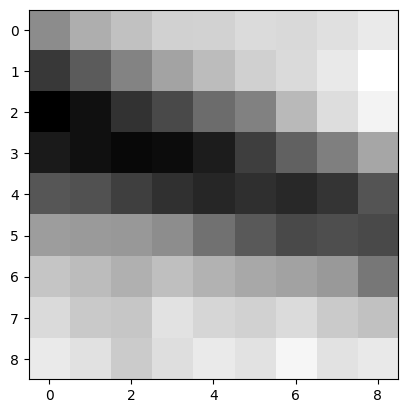

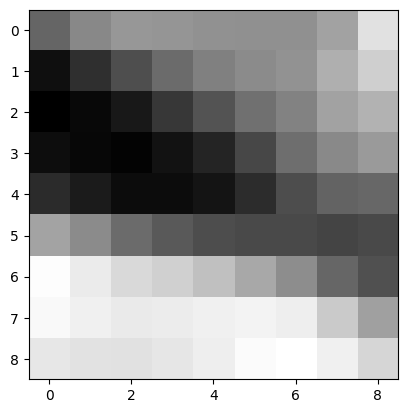

In [11]:
i = 80
j = 100
k = 80

lr_patch = np.copy(lowres_input[i - p_size_i - e_or_o : i + p_size_i,
                        j - p_size_i - e_or_o : j + p_size_i,
                        k - p_size_i - e_or_o : k + p_size_i, :])

hr_patch = np.copy(hires_output[
                        i - p_size_o - e_or_o : i + p_size_o,
                        j - p_size_o - e_or_o : j + p_size_o,
                        k - p_size_o - e_or_o : k + p_size_o, :])

lr_patch_mask = mask[i - p_size_i - e_or_o : i + p_size_i,
                        j - p_size_i - e_or_o : j + p_size_i,
                        k - p_size_i - e_or_o : k + p_size_i]

lr_patch[lr_patch_mask == 0] = 0

generated_image = generator(lr_patch[None,...], training=False)

# print(discriminator(hr_patch[None,...]))
# print(discriminator(generated_image))

plt.imshow(hr_patch[:, :, 3, 0], cmap='gray')
plt.figure()
plt.imshow(generated_image[0, :, :, 3, 0], cmap='gray')

In [12]:
result_image = np.zeros(hires_output.shape)

for (i, j, k) in tqdm(sel_indices):

    lr_patch = np.copy(lowres_input[i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, :])

    lr_patch_mask = mask[i - p_size_i - e_or_o : i + p_size_i,
                         j - p_size_i - e_or_o : j + p_size_i,
                         k - p_size_i - e_or_o : k + p_size_i]

    lr_patch[lr_patch_mask == 0] = 0

    generated_image = generator(lr_patch[None,...], training=False)

    result_image[i - p_size_o - e_or_o : i + p_size_o,
                 j - p_size_o - e_or_o : j + p_size_o,
                 k - p_size_o - e_or_o : k + p_size_o, :] = generated_image

result_image[mask == 0] = 0

100%|██████████| 1148/1148 [00:37<00:00, 30.56it/s]


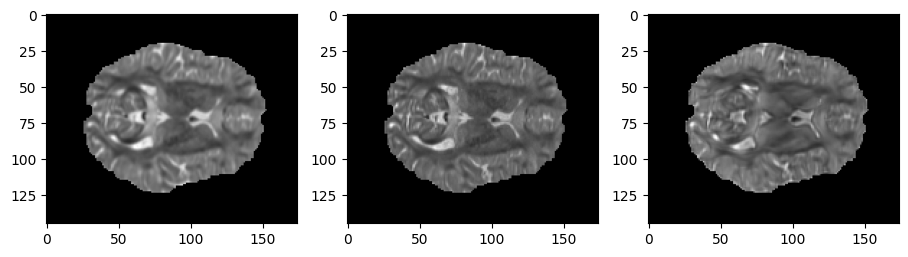

In [13]:
zdim = 60
channel = 0

# plt.imshow(lowres_input[:,:,zdim,channel], cmap='gray')
# plt.figure()
# plt.imshow(hires_output[:,:,zdim,channel], cmap='gray')
# plt.figure()
# plt.imshow(result_image[:,:,zdim,channel], cmap='gray')

fig = plt.figure(figsize=(11,16))

fig.add_subplot(1,3,1)
plt.imshow(lowres_input[:,:,zdim,channel], cmap='gray')#,vmax=2)
fig.add_subplot(1,3,2)
plt.imshow(hires_output[:,:,zdim,channel], cmap='gray')
fig.add_subplot(1,3,3)
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')#, vmax=3)

In [14]:
print(np.max(result_image[:,:,zdim,channel]))

0.9037482738494873


In [15]:
print(dti_preprocs_hr)

[[-1.05154882e-04  2.16340949e-03]
 [-5.41298650e-04  5.78155974e-04]
 [-5.87658025e-04  5.69419411e-04]
 [-1.25359482e-04  2.16784328e-03]
 [-5.46361203e-04  6.32987532e-04]
 [-8.55499675e-05  2.12963321e-03]]


In [16]:

# t1w_data_format[mask>0, :] = (t1w_data_format[mask>0, :] - t1w_preprocs[0] + 0.0001) / (t1w_preprocs[1] - t1w_preprocs[0])

result_orig_range = np.zeros(result_image.shape)

for i in range(6):

    result_orig_range[..., i] = ((result_image[..., i] * (dti_preprocs_lr[i,1] - dti_preprocs_lr[i,0])) - (0.0001 - dti_preprocs_lr[i,0]))

    result_orig_range[mask == 0, :] = 0

# for i in range(22):
#     nib.save(nib.Nifti1Image(result_image[:,:,:,i], h4_funcs[i+2]), "Data/Output/h4_all_{}.nii".format(str(i+3).zfill(2)))

In [17]:
for i in range(6):
    nib.save(nib.Nifti1Image(result_orig_range[...,i], dti_funcs[i+2]), "Data/Output/dt_all_{}.nii".format(str(i+3)))

In [18]:
[XSIZE, YSIZE, ZSIZE, dim] = result_orig_range.shape

gen_hires = np.zeros((XSIZE, YSIZE, ZSIZE, dim+2))

gen_hires[...,2:] = result_orig_range

gen_hires[...,0] = dti_imgs_lr[...,0]
gen_hires[...,1] = dti_imgs_lr[...,1]

In [19]:
print(XSIZE, YSIZE, ZSIZE)

145 174 145


In [20]:
def calc_MD_FA_CFA(dtis, XSIZE,YSIZE,ZSIZE):

    md = np.zeros((XSIZE,YSIZE,ZSIZE))
    fa = np.zeros((XSIZE,YSIZE,ZSIZE))
    cfa = np.zeros((XSIZE,YSIZE,ZSIZE,3))

    for i in tqdm(range(XSIZE)):
        for j in range(YSIZE):
            for k in range(ZSIZE):
                if dtis[i,j,k,2]>0:
                    ldt = dtis[i,j,k,:]

                    md[i,j,k] = (ldt[2]+ ldt[5] + ldt[7])/3

                    dt_mat = np.array([[ldt[2], ldt[3], ldt[4]], [ldt[3], ldt[5], ldt[6]], [ldt[4], ldt[6], ldt[7]]])

                    R, E = np.linalg.eigh(dt_mat)

                    fa[i,j,k] = np.sqrt(1.5*np.sum((R - R.mean())**2)/np.sum(R**2))
                    cfa[i, j, k,:] = fa[i,j,k] * np.abs(E[:, R.argmax()])

    return md, fa, cfa

In [21]:
md, fa, cfa = calc_MD_FA_CFA(gen_hires, XSIZE, YSIZE, ZSIZE)

100%|██████████| 145/145 [01:32<00:00,  1.56it/s]


In [22]:
dti_data_recon = np.zeros((XSIZE, YSIZE, ZSIZE, 8))

# dti_data_recon[..., 0:2] = dti_imgs[..., 0:2]

for i in range(1,9):
    # dti_data_recon[..., i] = ((dti_imgs[..., i] * (dti_preprocs_hr[i-2,1] - dti_preprocs_hr[i-2,0])) - (0.0001 - dti_preprocs_hr[i-2,0]))

    dti_data_recon[..., i-1] = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_{}.nii".format(subj,i)).get_fdata())

    # dti_data_recon[mask == 0, :] = 0

                            #((result_image[..., i] * (dti_preprocs_lr[i,1] - dti_preprocs_lr[i,0])) - (-dti_preprocs_lr[i,0]))

md_actual, fa_actual, cfa_actual = calc_MD_FA_CFA(dti_data_recon, XSIZE, YSIZE, ZSIZE)

100%|██████████| 145/145 [02:20<00:00,  1.03it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


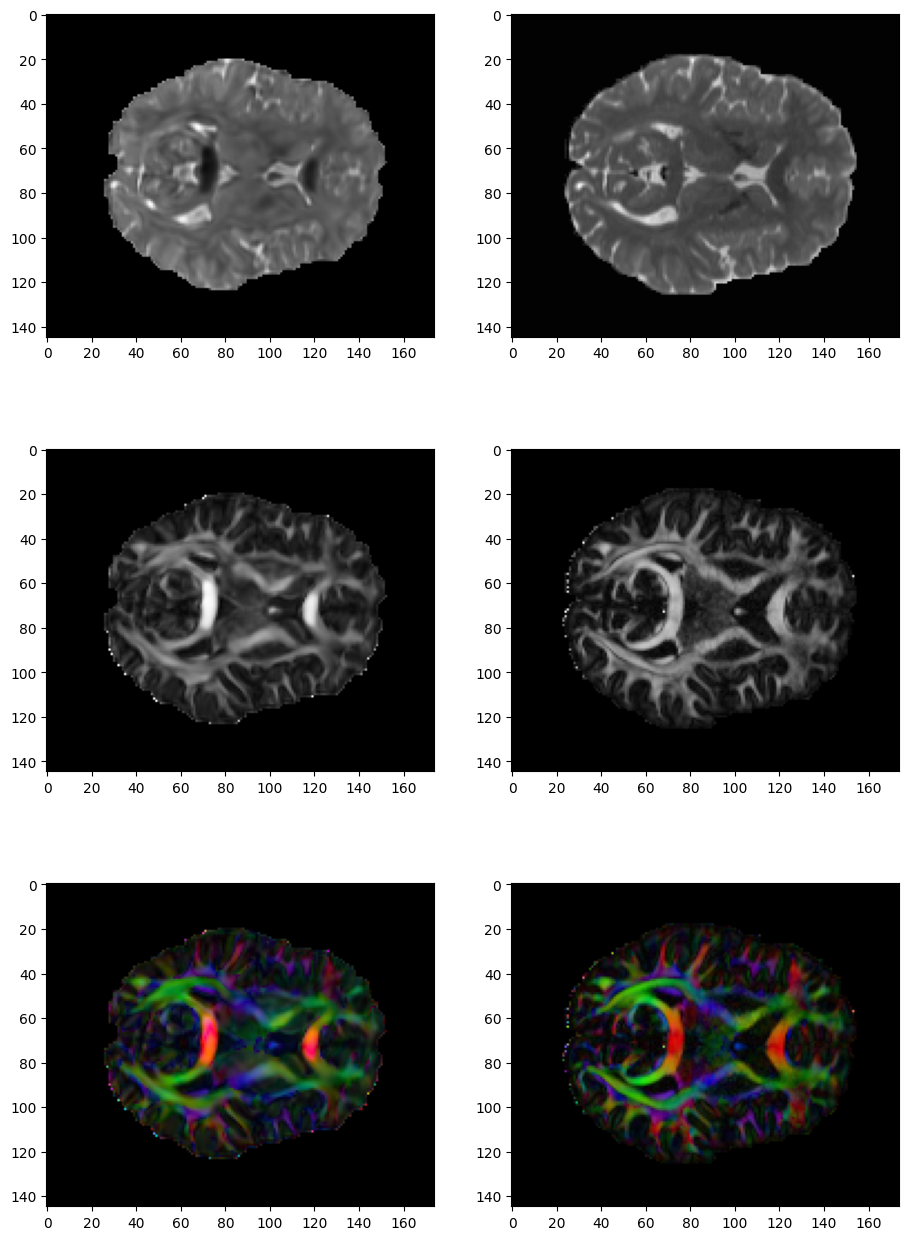

In [23]:
fig = plt.figure(figsize=(11,16))

fig.add_subplot(3,2,1)
plt.imshow(md[:,:,zdim], cmap='gray')
fig.add_subplot(3,2,2)
plt.imshow(md_actual[:,:,zdim], cmap='gray')
fig.add_subplot(3,2,3)
plt.imshow(fa[:,:,zdim], cmap='gray')
fig.add_subplot(3,2,4)
plt.imshow(fa_actual[:,:,zdim], cmap='gray')
fig.add_subplot(3,2,5)
plt.imshow(cfa[:,:,zdim], vmax=1)
fig.add_subplot(3,2,6)
plt.imshow(cfa_actual[:,:,zdim], vmax=1)